# Metadata
```
Author: Alice Bogdan (ucn3qn@virginia.edu)
Course: DS 5001
Date: 3 May 2022
Semester Project
Topic: Gilmore Girls
```

Purpose: Using ETA on Gilmore Girls tv scripts. Preprocess the data

Ends with creating DATA, CORPUS, and VOCAB tables. No tfidf or BOW.  

# Web Scrape Source Data (F0)

In [17]:
# import requests
# from lxml import etree
# import pandas as pd
# import numpy as np
# from io import StringIO
# from glob import glob
# import re

# series_id = 22
# outdir = './dump'
# base_url = "https://transcripts.foreverdreaming.org"

# parser = etree.HTMLParser()

# def get_pages(series_id, offset=0, outdir=''):
#     src_url = f"{base_url}/viewforum.php?f={series_id}&start={offset}"
#     r = requests.get(src_url)
#     tree = etree.parse(StringIO(r.text), parser)
#     page_urls = [f"{base_url}/{path[2:]}" for path in tree.xpath('//a[@class="topictitle"]/@href')]
#     for page_url in page_urls:
#         f, t, sid = page_url.split('?')[-1].split('&')
#         page_r = requests.get(page_url)
#         out_file_name = f"f{f.split('=')[-1]}-r{t.split('=')[-1]}.html"
#         with open(f"{outdir}/{out_file_name}", 'w') as out:
#             out.write(page_r.text)

# for offset in range(0, 175, 25):
#     print(offset)
#     get_pages(22, offset, outdir)

# xpaths = {
#        'title': "//div[@class='boxheading']/h2/text()",
#         'time': "//time/@datetime",
#         'content': "//div[@class='postbody']/p/text()"
# }

# data = []
# for page in glob(f"{outdir}/*.html"):
#     tree = etree.parse(page, parser)
#     title = tree.xpath(xpaths['title'])[0]
#     time = tree.xpath(xpaths['time'])[0]
#     lines = tree.xpath(xpaths['content'])    
#     for i, line in enumerate(lines):
#         data.append((title, time, i, line))
# df = pd.DataFrame(data, columns=['title_raw','time_raw','line_num','doc_raw'])

# df.to_csv(f'{data_home}/output/{data_prefix}.csv')

# Set Up

In [18]:
#libraries
import pandas as pd
import numpy as np
import nltk
# from sklearn.decomposition import PCA
from scipy.linalg import norm
import plotly.express as px
import seaborn as sns; sns.set()
import re

In [19]:
#nltk.download('stopwords')

# Outputs from this Notebook

In [20]:
data_home = "data"
data_prefix = 'Gilmore_Girls'

# Load Data

In [21]:
#import data
DATA = pd.read_csv(f"{data_home}/output/{data_prefix}.csv")

In [22]:
#split title_raw into three columns: Season, Episode, and Title
DATA[['Season', 'Title']] = DATA['title_raw'].str.split('-', n = 1, expand = True)
DATA[['Season', 'Episode']] = DATA['Season'].str.split('x', n = 1, expand = True)

In [23]:
#remove whitespace
DATA['Episode'] = DATA['Episode'].str.strip()
DATA['Season'] = DATA['Season'].str.strip()

In [24]:
#subset data to remove Unamed: 0 and title_raw
DATA = DATA[["Season", "Episode", "Title","time_raw","line_num","doc_raw"]]

need to:
cut by scene
get rid of anything in [] or ()
capture names starts with all caps followed : 

In [25]:
#keep only seasons 1-7 (season 8 is an exception)
DATA = DATA[DATA['Season'].isin(['01', '02', '03', '04', '05', '06', '07'])]
DATA = DATA.sort_values(['Season', 'Episode'])

In [26]:
#not every episode has scenes
DATA[DATA['doc_raw'].str.contains("cut to", case = False)][0:25]

,Season,Episode,Title,time_raw,line_num,doc_raw
61833,01,01,The Pilot,2000-10-17T15:42:16Z,80,CUT TO THE INDEPENDENCE INN
61878,01,01,The Pilot,2000-10-17T15:42:16Z,125,CUT TO OUTSIDE
61897,01,01,The Pilot,2000-10-17T15:42:16Z,144,CUT TO CLASSROOM
61906,01,01,The Pilot,2000-10-17T15:42:16Z,153,CUT TO THE INDEPENDENCE INN
61943,01,01,The Pilot,2000-10-17T15:42:16Z,190,CUT TO OUTSIDE
61999,01,01,The Pilot,2000-10-17T15:42:16Z,246,CUT TO INDEPENDENCE INN KITCHEN
62059,01,01,The Pilot,2000-10-17T15:42:16Z,306,CUT TO INDEPENDENCE INN LOBBY
62069,01,01,The Pilot,2000-10-17T15:42:16Z,316,CUT TO LORELAI'S HOUSE
62072,01,01,The Pilot,2000-10-17T15:42:16Z,319,CUT TO LORELAI'S FRONT PORCH
62121,01,01,The Pilot,2000-10-17T15:42:16Z,368,CUT TO ELDER GILMORE RESIDENCE


# Preprocessing

Output data has been saved and can be uploaded

## Remove stage directions

In [27]:
#regex to capture lines beginning and ending with [] or () indicating stage directions
stage_dir = r"(\(.*\))|(\[.*\])"

In [28]:
#COPY = DATA.copy()

In [29]:
#run regex code to find lines with stage directions
stage_lines = DATA.doc_raw.str.match(stage_dir, case=False) # Returns a truth vector

In [30]:
#remove stage direction lines
DATA = DATA.loc[-stage_lines]

In [31]:
#remove stage directions found within lines
DATA['doc_raw'] = DATA['doc_raw'].replace(regex = stage_dir, value='')

In [32]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61753,01,01,The Pilot,2000-10-17T15:42:16Z,0,1.01 - Pilot
61754,01,01,The Pilot,2000-10-17T15:42:16Z,1,written by Amy Sherman-Palladino
61755,01,01,The Pilot,2000-10-17T15:42:16Z,2,directed by Lesli Linka Glatter
61756,01,01,The Pilot,2000-10-17T15:42:16Z,3,OPEN IN STARS HOLLOW
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
...,...,...,...,...,...,...
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...
100869,07,22,Bon Voyage,2007-05-27T10:54:44Z,811,RORY: I guess so.


## Capture Characters

In [33]:
#regex to capture characters (example, "RORY:"")
#char_pat = r"^[A-Z]*.? ?:" #does not capture MRS. KIM:
char_pat = r"^[A-Z]*\.?\s?[A-Z]*:" #captures MRS. KIM:

In [34]:
#find all lines that begin with character talking
char_lines = DATA.doc_raw.str.match(char_pat, case=False) # Returns a truth vector

In [35]:
#filter data for only lines where characters talk
#this also removes fluff lines such as the director, episode number, "OPEN IN", "THE END", etc
DATA = DATA.loc[char_lines]

In [36]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE: How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI: None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE: Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,"LORELAI: Five, but yours is better."
...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY: Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...


## Split doc_raw to form column for characters

In [37]:
DATA[['Character', 'lines']] = DATA['doc_raw'].str.split(':', n = 1, expand = True)

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [38]:
DATA = DATA[["Season","Episode","Title","time_raw","line_num","Character","lines"]]

In [39]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better."
...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.


In [40]:
DATA['Character'] = DATA['Character'].str.strip()
DATA['Character'] = DATA['Character'].str.upper()

<ipython-input-40-d8d10a87a192>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.strip()
<ipython-input-40-d8d10a87a192>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.upper()


In [41]:
DATA['Character'].sort_values().unique()

array(['', 'ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANOTHER MAN',
       'ANSWERING MACHINE', 'ANTONIA', 'APRIL', 'ARLETTA', 'ARTHUR',
       'ASHER', 'ASIAN CAESAR', 'ATTENDANT', 'AUBREY', 'AUCTIONEER',
       'AUDREY', 'AUNT JUN', 'AURORA', 'AVA', 'AYOR', 'BABETE', 'BABETTE',
       'BAND', 'BAND TEACHER', 'BARBARA', 'BARBETTE', 'BARRY',
       'BARTENDER', 'BEARDED CUSTOMER', 'BEATRICE', 'BEAU', 'BELLBOY',
       'BEN', 'BENNY', 'BERT', 'BEVERLY', 'BIKE GUY', 'BIKER', 'BIKERS',
       'BILL', 'BILLY', 'BING CROSBY', 'BOB', 'BOBBI', 'BOBBY', 'BONNIE',
       'BOOTSY', 'BOOZOO', 'BOTH', 'BOUNCER', 'BOY', 'BOYS', 'BRAD',
       'BRADLEY', 'BRAIN', 'BRANDON', 'BREAD GUY', 'BRENNON', 'BRIAN',
       'BRIDE', 'BRUCE', 'BRUNETTE', 'BUDDY', 'BUTCHER', 'CAESAR',
       'CAESER', 'CAITLYN', 'CARL', 'CAROL', 'CAROLE', 'CAROLINE',
       'CAROLYN', 'CARRIE', 'CARY

In [42]:
DATA[DATA['Character'] == "MADONNA LOUISE"]

,Season,Episode,Title,time_raw,line_num,Character,lines
126936,05,03,Written in the Stars,2004-10-17T05:28:49Z,47,MADONNA LOUISE,Dinner is served in the main house.
126939,05,03,Written in the Stars,2004-10-17T05:28:49Z,50,MADONNA LOUISE,But the madam is ready now.
127073,05,03,Written in the Stars,2004-10-17T05:28:49Z,184,MADONNA LOUISE,I told his valet about it.
127075,05,03,Written in the Stars,2004-10-17T05:28:49Z,186,MADONNA LOUISE,"Yes, Mrs. Gilmore."
127568,05,03,Written in the Stars,2004-10-17T05:28:49Z,679,MADONNA LOUISE,"Can I get you some dessert, Mrs. Gilmore?"
127570,05,03,Written in the Stars,2004-10-17T05:28:49Z,681,MADONNA LOUISE,"Very good, Mrs. Gilmore."
127572,05,03,Written in the Stars,2004-10-17T05:28:49Z,683,MADONNA LOUISE,"I won't, Mrs. Gilmore."
127574,05,03,Written in the Stars,2004-10-17T05:28:49Z,685,MADONNA LOUISE,I sprayed for ants this afternoon.
127576,05,03,Written in the Stars,2004-10-17T05:28:49Z,687,MADONNA LOUISE,I know Mrs. Gilmore.
127578,05,03,Written in the Stars,2004-10-17T05:28:49Z,689,MADONNA LOUISE,"Okay, Mrs. Gilmore."


In [43]:
#remove directed by lines
DATA = DATA[DATA['Character'] != "DIRECTED BY"]
DATA = DATA[DATA['Character'] != "WRITTEN BY"]
DATA = DATA[DATA['Character'] != "OFF SCREEN"]

In [44]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better."
...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.


In [45]:
#it's Rory
DATA[DATA['Character'] == ""]

,Season,Episode,Title,time_raw,line_num,Character,lines
17465,01,20,P.S. I Lo...,2001-05-15T14:32:16Z,782,,Please.


In [46]:
DATA['Episode'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype=object)

In [47]:
#incorrect names lists
lorelai_sp = ['LOREAI', 'LOREALI', 'LORELA', 'LORELAIL', 'LORELI', 'LORLAI', 'LORLEAI', 'LORLELAI', 'L','ORELAI']
luke_sp = ['LUK','FILM LUKE']
rory_sp = ['R',"",'ORY']
richard_sp = ['RICHRAD','GRANDPA']
emily_sp = ['EMIL','GRANDMOTHER','GRANDMA','RMILY','EMILY VOICE']
sookie_sp = ['SOOKEI', 'SOOKI', 'SOOKIES']
caesar_sp = ['CAESER']
christopher_sp = ['CHRISTOHPER','CHRISTOPER','CHRSTOPHER','CHRISTOPER','CHRIS']
lindsay_sp = ['LINDAY','LINDSAY VOICE'] #dean's wife
headmaster_sp = ['CHARLESTON','HDM. CHARLESTON']
babette_sp = ['BABETE','BARBETTE']
logan_sp = ['LOG']
trix_sp = ['GRAN'] #Lorelai the first
michel_sp = ['MICHE','MICHELL']
tristin_sp = ['TRISTAN','MR. DUGRAY']
troubadour_sp = ['TROUBADOR']
tanna_sp = ['TANA'] #Rory's college roommate
prof_sp = ['PROFERSSOR']
brian_sp = ['BRAIN'] #band member
taylor_sp = ['TAYOR']
mrs_kim_sp = ['MRS. KIM','MRS KIM']
patty_sp = ['MISS PATTY']
max_sp = ['MR. MEDINA']
rev_skinner_sp = ['REV.SKINNER']

In [48]:
#replace incorrect names with correct names
DATA['Character'] = DATA['Character'].replace(lorelai_sp, value = 'LORELAI')
DATA['Character'] = DATA['Character'].replace(luke_sp, value = 'LUKE')
DATA['Character'] = DATA['Character'].replace(rory_sp, value = 'RORY')
DATA['Character'] = DATA['Character'].replace(richard_sp, value = 'RICHARD')
DATA['Character'] = DATA['Character'].replace(emily_sp, value = 'EMILY')
DATA['Character'] = DATA['Character'].replace(sookie_sp, value = 'SOOKIE')
DATA['Character'] = DATA['Character'].replace(caesar_sp, value = 'CAESAR')
DATA['Character'] = DATA['Character'].replace(christopher_sp, value = 'CHRISTOPHER')
DATA['Character'] = DATA['Character'].replace(lindsay_sp, value = 'LINDSAY')
DATA['Character'] = DATA['Character'].replace(headmaster_sp, value = 'HEADMASTER')
DATA['Character'] = DATA['Character'].replace(babette_sp, value = 'BABETTE')
DATA['Character'] = DATA['Character'].replace(logan_sp, value = 'LOGAN')
DATA['Character'] = DATA['Character'].replace(trix_sp, value = 'TRIX')
DATA['Character'] = DATA['Character'].replace(michel_sp, value = 'MICHEL')
DATA['Character'] = DATA['Character'].replace(tristin_sp, value = 'TRISTIN')
DATA['Character'] = DATA['Character'].replace(troubadour_sp, value = 'TROUBADOUR')
DATA['Character'] = DATA['Character'].replace(tanna_sp, value = 'TANNA')
DATA['Character'] = DATA['Character'].replace(prof_sp, value = 'PROFESSOR')
DATA['Character'] = DATA['Character'].replace(brian_sp, value = 'BRIAN')
DATA['Character'] = DATA['Character'].replace(taylor_sp, value = 'TAYLOR')
DATA['Character'] = DATA['Character'].replace(mrs_kim_sp, value = 'MRS.KIM')
DATA['Character'] = DATA['Character'].replace(patty_sp, value = 'PATTY')
DATA['Character'] = DATA['Character'].replace(max_sp, value = 'MAX')
DATA['Character'] = DATA['Character'].replace(rev_skinner_sp, value = 'REVEREND SKINNER')


In [49]:
DATA['Character'].sort_values().unique()

array(['ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANOTHER MAN',
       'ANSWERING MACHINE', 'ANTONIA', 'APRIL', 'ARLETTA', 'ARTHUR',
       'ASHER', 'ASIAN CAESAR', 'ATTENDANT', 'AUBREY', 'AUCTIONEER',
       'AUDREY', 'AUNT JUN', 'AURORA', 'AVA', 'AYOR', 'BABETTE', 'BAND',
       'BAND TEACHER', 'BARBARA', 'BARRY', 'BARTENDER',
       'BEARDED CUSTOMER', 'BEATRICE', 'BEAU', 'BELLBOY', 'BEN', 'BENNY',
       'BERT', 'BEVERLY', 'BIKE GUY', 'BIKER', 'BIKERS', 'BILL', 'BILLY',
       'BING CROSBY', 'BOB', 'BOBBI', 'BOBBY', 'BONNIE', 'BOOTSY',
       'BOOZOO', 'BOTH', 'BOUNCER', 'BOY', 'BOYS', 'BRAD', 'BRADLEY',
       'BRANDON', 'BREAD GUY', 'BRENNON', 'BRIAN', 'BRIDE', 'BRUCE',
       'BRUNETTE', 'BUDDY', 'BUTCHER', 'CAESAR', 'CAITLYN', 'CARL',
       'CAROL', 'CAROLE', 'CAROLINE', 'CAROLYN', 'CARRIE', 'CARY GRANT',
       'CASHIER', 'CATHERINE', 'CELINE', 'C

In [50]:
DATA[DATA['Character'] == 'MRS SINCLAIR']

,Season,Episode,Title,time_raw,line_num,Character,lines
21332,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,159,MRS SINCLAIR,We've been dreaming about the festival since ...
21336,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,163,MRS SINCLAIR,He did. I had to get my hair dryer and an ext...
21845,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,672,MRS SINCLAIR,"I don't think so sweetie it's just a maze, bu..."
21859,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,686,MRS SINCLAIR,"Co o on, let's go!"


In [51]:
#extract year
DATA['Year'] = DATA.time_raw.str.split('-', n = 1, expand = True)[0]

In [52]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000
...,...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.,2007
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...,2007
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.,2007
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.,2007


In [53]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000
...,...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.,2007
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...,2007
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.,2007
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.,2007


# Create LIB

## LIB by Season

In [54]:
LIB = DATA.copy()

In [55]:
#add show title
LIB['Show'] = 'Gilmore Girls'

In [56]:
#subset data
LIB = LIB[['Show','Season','Episode','Title','Year','line_num','Character','lines']]

In [57]:
#count the number of epsiodes per season
LIB['Num_Episodes'] = LIB.groupby(['Season'])['Episode'].transform('nunique')
#count the number of lines per season
LIB['Num_Lines'] = LIB.groupby('Season')['Season'].transform('count')

In [58]:
#separate library
LIB2 = LIB.copy()

In [59]:
#subset to the number of seasons in the show
LIB = LIB.drop_duplicates(['Season'])

In [60]:
#subset data
LIB = LIB[['Show','Season','Num_Episodes','Year','Num_Lines']]

In [61]:
#reset index
LIB = LIB.reset_index(drop = True).set_index('Show')

In [62]:
LIB

,Season,Num_Episodes,Year,Num_Lines
Show,,,,
Gilmore Girls,01,21,2000,16031
Gilmore Girls,02,22,2001,18264
Gilmore Girls,03,22,2002,17699
Gilmore Girls,04,22,2003,17806
Gilmore Girls,05,22,2004,16737
Gilmore Girls,06,22,2005,16145
Gilmore Girls,07,22,2006,15188


## LIB by Episode

In [63]:
#count the number of lines per season and episode
LIB2['Num_Lines_per_Episode'] = LIB2.groupby(['Season','Episode'])['Season'].transform('count')

In [64]:
#unique episodes
LIB2 = LIB2.drop_duplicates(['Title'])

In [65]:
#subset the data
LIB2 = LIB2[['Show','Season','Num_Episodes','Episode','Title','Year','Num_Lines_per_Episode']]

In [66]:
#reset index
LIB2 = LIB2.reset_index(drop = True).set_index('Show')

In [67]:
#rename column
LIB2.rename(columns={"Num_Episodes":"Num_Episodes_per_Season"}, inplace=True)

In [68]:
LIB2

,Season,Num_Episodes_per_Season,Episode,Title,Year,Num_Lines_per_Episode
Show,,,,,,
Gilmore Girls,01,21,01,The Pilot,2000,630
Gilmore Girls,01,21,02,The Lorelai's First Day at Chilton,2000,586
Gilmore Girls,01,21,03,k*ll Me Now,2000,698
Gilmore Girls,01,21,04,The Deer Hunters,2000,717
Gilmore Girls,01,21,05,Rory's Birthday Parties,2000,753
...,...,...,...,...,...,...
Gilmore Girls,07,22,18,Hay Bale Maze,2007,753
Gilmore Girls,07,22,19,It's Just Like Riding A Bike,2007,791
Gilmore Girls,07,22,20,Lorelai? Lorelai?,2007,699


# Create Standard Text Analytics Data Models (F2)

## Creating a  `CORPUS` Table

In [69]:
DATA.head()

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000


In [70]:
#OHCO structure of DATA
OHCO = ['Season','Episode','line_num','Character','sent_num','token_num']

In [71]:
#reference for convenience
SEAS = OHCO[:1]
EPI = OHCO[:2]
LINE = OHCO[:3]
CHAR = OHCO[:4]
SENT = OHCO[:5]
TOKEN = OHCO[:6]

In [72]:
#subset DATA to include only these columns
GG = DATA[['Season','Episode','line_num','Character','lines']]

In [73]:
#GG['lines'] = GG['lines'].str.strip()

In [74]:
#begin the process of tokenizing data
#SEASONS = GG.set_index(SEAS)
#EPISODES = GG.set_index(EPI)
#CHARACTERS = GG.set_index(CHAR)
CHARACTERS = GG.set_index(CHAR)
#SENT = GG.set_index(SENT)
#TOKENS2 = GG.set_index(TOKEN)

In [75]:
CHARACTERS

lines
Season Episode line_num Character                                                   
01     01      5        LORELAI               Please, Luke. Please, please, please. 
               6        LUKE               How many cups have you had this morning? 
               7        LORELAI                                               None. 
               8        LUKE                                                Plus... 
               9        LORELAI                          Five, but yours is better. 
...                                                                              ...
07     22      807      RORY                         Well It wasn't very flattering.
               808      LORELAI     Well how will people know you're the world's ...
               809      RORY                                           I don't know.
               810      LORELAI        I guess they'll just have to read your stuff.
               811      RORY                                             I guess so.

[117870 rows x 1 columns]

## Split lines into sentences

In [76]:
#split lines into sentences
sent_pat = r'[.?!;:]+'
SENTS = CHARACTERS['lines'].str.split(sent_pat, expand=True).stack()\
    .to_frame('sent_str')
SENTS.index.names = SENT

In [77]:
SENTS

sent_str
Season Episode line_num Character sent_num                                               
01     01      5        LORELAI   0                                          Please, Luke
                                  1                                Please, please, please
                                  2                                                      
               6        LUKE      0               How many cups have you had this morning
                                  1                                                      
...                                                                                   ...
07     22      809      RORY      1                                                      
               810      LORELAI   0          I guess they'll just have to read your stuff
                                  1                                                      
               811      RORY      0                                            I guess so
                                  1                                                      

[298012 rows x 1 columns]

In [78]:
SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs
SENTS.sent_str = SENTS.sent_str.str.strip() # CRUCIAL TO REMOVE BLANK TOKENS

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [79]:
SENTS

sent_str
Season Episode line_num Character sent_num                                                   
01     01      5        LORELAI   0                                              Please, Luke
                                  1                                    Please, please, please
               6        LUKE      0                   How many cups have you had this morning
               7        LORELAI   0                                                      None
               8        LUKE      0                                                      Plus
...                                                                                       ...
07     22      807      RORY      0                            Well It wasn't very flattering
               808      LORELAI   0         Well how will people know you're the world's g...
               809      RORY      0                                              I don't know
               810      LORELAI   0              I guess they'll just have to read your stuff
               811      RORY      0                                                I guess so

[180023 rows x 1 columns]

## Split sentences into tokens

In [80]:
#add "'" *apostrophe to remove cases like "lukes". Will convert to "luke" and "s"
token_pat = r"[\s,-]+"
TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
    .to_frame('token_str')
TOKENS.index.names = TOKEN

In [81]:
TOKENS.head()

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please

In [82]:
#remove blank tokens
TOKENS = TOKENS[TOKENS.token_str != '']

In [83]:
TOKENS

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please
...                                                        ...
07     22      810      LORELAI   0        7              your
                                           8             stuff
               811      RORY      0        0                 I
                                           1             guess
                                           2                so

[1097220 rows x 1 columns]

# Annotate Tables with Statistical and Linguisitic Features (F3)

## Add POS to TOKENS

In [84]:
# Sentences to Tokens
# Local function to pick tokenizer
def word_tokenize(x):
    if ws:
        s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
    else:
        s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
    return s

In [85]:
#whitespace variable
ws = True

In [86]:
#TEST_T = TOKENS.copy()

In [87]:
#add POS as tuple (word, POS)
TOKENS = TOKENS.token_str.apply(word_tokenize).stack().to_frame().rename(columns = {0:'pos_tuple'})

In [88]:
#reset index
TOKENS = TOKENS.reset_index()
#remove extra column
TOKENS = TOKENS[['Season','Episode','line_num','Character','sent_num','token_num','pos_tuple']]
#set index back to OHCO[:6] aka TOKEN
TOKENS = TOKENS.set_index(TOKEN)
TOKENS

pos_tuple
Season Episode line_num Character sent_num token_num              
01     01      5        LORELAI   0        0          (Please, VB)
                                           1            (Luke, NN)
                                  1        0          (Please, VB)
                                           1          (please, NN)
                                           2          (please, NN)
...                                                            ...
07     22      810      LORELAI   0        7          (your, PRP$)
                                           8           (stuff, NN)
               811      RORY      0        0              (I, PRP)
                                           1           (guess, NN)
                                           2              (so, RB)

[1097220 rows x 1 columns]

In [89]:
#isolate POS
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
#isolate token from pos_tuple
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])

In [90]:
#set index names as OHCO[:6] aka TOKEN
TOKENS.index.names = TOKEN
TOKENS

pos_tuple   pos  \
Season Episode line_num Character sent_num token_num                       
01     01      5        LORELAI   0        0          (Please, VB)    VB   
                                           1            (Luke, NN)    NN   
                                  1        0          (Please, VB)    VB   
                                           1          (please, NN)    NN   
                                           2          (please, NN)    NN   
...                                                            ...   ...   
07     22      810      LORELAI   0        7          (your, PRP$)  PRP$   
                                           8           (stuff, NN)    NN   
               811      RORY      0        0              (I, PRP)   PRP   
                                           1           (guess, NN)    NN   
                                           2              (so, RB)    RB   

                                                     token_str  
Season Episode line_num Character sent_num token_num            
01     01      5        LORELAI   0        0            Please  
                                           1              Luke  
                                  1        0            Please  
                                           1            please  
                                           2            please  
...                                                        ...  
07     22      810      LORELAI   0        7              your  
                                           8             stuff  
               811      RORY      0        0                 I  
                                           1             guess  
                                           2                so  

[1097220 rows x 3 columns]

## Extract Vocab

In [91]:
#remove non-word characters and replace with blank. Then lowercase all letters
TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower()

In [92]:
TOKENS = TOKENS.reset_index()

In [93]:
TOKENS

,Season,Episode,line_num,Character,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,01,01,5,LORELAI,0,0,"(Please, VB)",VB,Please,please
1,01,01,5,LORELAI,0,1,"(Luke, NN)",NN,Luke,luke
2,01,01,5,LORELAI,1,0,"(Please, VB)",VB,Please,please
3,01,01,5,LORELAI,1,1,"(please, NN)",NN,please,please
4,01,01,5,LORELAI,1,2,"(please, NN)",NN,please,please
...,...,...,...,...,...,...,...,...,...,...
1097215,07,22,810,LORELAI,0,7,"(your, PRP$)",PRP$,your,your
1097216,07,22,810,LORELAI,0,8,"(stuff, NN)",NN,stuff,stuff
1097217,07,22,811,RORY,0,0,"(I, PRP)",PRP,I,i
1097218,07,22,811,RORY,0,1,"(guess, NN)",NN,guess,guess


In [94]:
#normalize ok
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^ok$', value = 'okay', regex = True)
#normalize creme
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^crme$', value = 'crème', regex = True)
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^creme$', value = 'crème', regex = True)
#normalize brulee
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^brlée$', value = 'brûlée', regex = True)
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^blée$', value = 'brûlée', regex = True)
TOKENS['term_str'] = TOKENS['term_str'].replace(to_replace ='^broule$', value = 'brûlée', regex = True)

In [95]:
#remove blank tokens
TOKENS = TOKENS[TOKENS['term_str'] != ""]

In [96]:
#Nan is a name
#TOKENS[TOKENS['term_str'] == "nan"]

In [97]:
TOKENS = TOKENS.set_index(OHCO)
TOKENS

pos_tuple   pos  \
Season Episode line_num Character sent_num token_num                       
01     01      5        LORELAI   0        0          (Please, VB)    VB   
                                           1            (Luke, NN)    NN   
                                  1        0          (Please, VB)    VB   
                                           1          (please, NN)    NN   
                                           2          (please, NN)    NN   
...                                                            ...   ...   
07     22      810      LORELAI   0        7          (your, PRP$)  PRP$   
                                           8           (stuff, NN)    NN   
               811      RORY      0        0              (I, PRP)   PRP   
                                           1           (guess, NN)    NN   
                                           2              (so, RB)    RB   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0            Please   please  
                                           1              Luke     luke  
                                  1        0            Please   please  
                                           1            please   please  
                                           2            please   please  
...                                                        ...      ...  
07     22      810      LORELAI   0        7              your     your  
                                           8             stuff    stuff  
               811      RORY      0        0                 I        i  
                                           1             guess    guess  
                                           2                so       so  

[1094621 rows x 4 columns]

In [98]:
TOKENS.query("term_str == 'luke'")

pos_tuple pos  \
Season Episode line_num Character sent_num token_num                   
01     01      5        LORELAI   0        1          (Luke, NN)  NN   
       02      410      LORELAI   0        7          (Luke, NN)  NN   
               753      LORELAI   0        6          (Luke, NN)  NN   
               756      RORY      2        3          (Luke, NN)  NN   
               757      LORELAI   0        5          (Luke, NN)  NN   
...                                                          ...  ..   
07     22      687      MAN       0        1          (Luke, NN)  NN   
               721      SOOKIE    1        3          (Luke, NN)  NN   
               723      SOOKIE    1        3          (Luke, NN)  NN   
               730      TAYLOR    0        4          (Luke, NN)  NN   
               740      LORELAI   0        0          (Luke, NN)  NN   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        1              Luke     luke  
       02      410      LORELAI   0        7              Luke     luke  
               753      LORELAI   0        6              Luke     luke  
               756      RORY      2        3              Luke     luke  
               757      LORELAI   0        5              Luke     luke  
...                                                        ...      ...  
07     22      687      MAN       0        1              Luke     luke  
               721      SOOKIE    1        3              Luke     luke  
               723      SOOKIE    1        3              Luke     luke  
               730      TAYLOR    0        4              Luke     luke  
               740      LORELAI   0        0              Luke     luke  

[1447 rows x 4 columns]

In [99]:
TOKENS.query("term_str == 'midgets'")

pos_tuple  pos  \
Season Episode line_num Character sent_num token_num                        
01     03      189      MICHEL    0        6          (midgets, NNS)  NNS   
02     17      652      SOOKIE    0        2          (midgets, NNS)  NNS   
               656      MICHEL    1        8          (midgets, NNS)  NNS   
               670      LORELAI   0        5          (midgets, NNS)  NNS   
               679      SOOKIE    0        3          (midgets, NNS)  NNS   
               780      LORELAI   1        7          (midgets, NNS)  NNS   
               781      EMILY     0        2          (midgets, NNS)  NNS   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     03      189      MICHEL    0        6           midgets  midgets  
02     17      652      SOOKIE    0        2           midgets  midgets  
               656      MICHEL    1        8           midgets  midgets  
               670      LORELAI   0        5           midgets  midgets  
               679      SOOKIE    0        3           midgets  midgets  
               780      LORELAI   1        7           midgets  midgets  
               781      EMILY     0        2           midgets  midgets

In [100]:
#add count
VOCAB = TOKENS.term_str.value_counts().to_frame('n')

In [101]:
VOCAB.head(20)

,n
i,38882
you,38256
the,31072
to,26174
a,23702
and,20591
it,15656
that,12660
of,11992
is,10378


In [102]:
VOCAB.index.name = 'term_str'

Reference for variable names in VOCAB    
n:       count  
n_chars: len of term  
p:       probability  
s:       surpise  
i:       information  
h:       entropy  

In [103]:
#add other variables to VOCAB as described above
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB['n'] / VOCAB['n'].sum()
VOCAB['s'] = 1 / VOCAB['p']
VOCAB['i'] = np.log2(VOCAB['s']) # Same as negative log probability (i.e. log likelihood)
VOCAB['h'] = VOCAB['p'] * VOCAB['i'] 
H = VOCAB['h'].sum()

In [104]:
VOCAB

,n,n_chars,p,s,i,h
term_str,,,,,,
i,38882,1,3.552097e-02,2.815238e+01,4.815185,0.171040
you,38256,3,3.494908e-02,2.861305e+01,4.838602,0.169105
the,31072,3,2.838608e-02,3.522853e+01,5.138673,0.145867
to,26174,2,2.391147e-02,4.182093e+01,5.386153,0.128791
a,23702,1,2.165316e-02,4.618264e+01,5.529279,0.119726
...,...,...,...,...,...,...
substandard,1,11,9.135582e-07,1.094621e+06,20.062000,0.000018
outhouse,1,8,9.135582e-07,1.094621e+06,20.062000,0.000018
renown,1,6,9.135582e-07,1.094621e+06,20.062000,0.000018


# Annotate VOCAB

## Get Max POS (Part-of-Speech)

In [105]:
#extract maximum POS
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value = 0).idxmax(1)

In [106]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos
term_str,,,,,,,
i,38882,1,0.035521,28.152384,4.815185,0.171040,PRP
you,38256,3,0.034949,28.613054,4.838602,0.169105,PRP
the,31072,3,0.028386,35.228534,5.138673,0.145867,DT
to,26174,2,0.023911,41.820929,5.386153,0.128791,TO
a,23702,1,0.021653,46.182643,5.529279,0.119726,DT


## Compute POS Ambiguity

In [107]:
#count of POS
VOCAB['n_pos'] = TOKENS[['term_str','pos']].value_counts().unstack().count(1)

In [108]:
#all POS categories
VOCAB['cat_pos'] = TOKENS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [109]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos
term_str,,,,,,,,,
i,38882,1,3.552097e-02,2.815238e+01,4.815185,0.171040,PRP,3,"{NN, NNS, PRP}"
you,38256,3,3.494908e-02,2.861305e+01,4.838602,0.169105,PRP,3,"{NN, NNS, PRP}"
the,31072,3,2.838608e-02,3.522853e+01,5.138673,0.145867,DT,3,"{NN, NNS, DT}"
to,26174,2,2.391147e-02,4.182093e+01,5.386153,0.128791,TO,3,"{TO, NN, NNS}"
a,23702,1,2.165316e-02,4.618264e+01,5.529279,0.119726,DT,3,"{NN, NNS, DT}"
...,...,...,...,...,...,...,...,...,...
substandard,1,11,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN}
outhouse,1,8,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN}
renown,1,6,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN}


## Add Stopwords

In [110]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [111]:
sw

,dummy
term_str,
i,1
me,1
my,1
myself,1
we,1
...,...
weren't,1
won,1
won't,1


In [112]:
sw = sw.reset_index()
sw

,term_str,dummy
0,i,1
1,me,1
2,my,1
3,myself,1
4,we,1
...,...,...
174,weren't,1
175,won,1
176,won't,1
177,wouldn,1


In [113]:
apos_pat = r"[']"

In [114]:
sw['term_str_WOA'] = sw['term_str'].str.replace("'","")

In [115]:
sw = sw[['term_str_WOA','dummy']]
sw = sw.set_index('term_str_WOA')

In [116]:
sw

,dummy
term_str_WOA,
i,1
me,1
my,1
myself,1
we,1
...,...
werent,1
won,1
wont,1


In [128]:
#VOCAB.index.map(sw.dummy)
#sw[sw.index.duplicated()]
sw = sw.reset_index()

,term_str_WOA,dummy


In [127]:
sw.drop_duplicates(subset = 'term_str_WOA', keep = False, inplace = True)

In [129]:
sw = sw.set_index('term_str_WOA')

In [130]:
#stop words classified as 1, else 0
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [131]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
if,3783,2,0.003456,289.352630,8.176685,0.028259,IN,2,"{NN, IN}",1
are,6084,3,0.005558,179.917982,7.491196,0.041637,VBP,2,"{NN, VBP}",1
some,2096,4,0.001915,522.242844,9.028577,0.017288,DT,2,"{NN, DT}",1
wouldnt,489,7,0.000447,2238.488753,11.128309,0.004971,NN,1,{NN},1
is,10378,2,0.009481,105.475140,6.720759,0.063719,VBZ,2,"{VBZ, NN}",1
this,8367,4,0.007644,130.825983,7.031505,0.053747,DT,3,"{NN, NNS, DT}",1
at,4271,2,0.003902,256.291501,8.001642,0.031221,IN,2,"{NN, IN}",1
had,2057,3,0.001879,532.144385,9.055674,0.017017,VBD,1,{VBD},1
do,6425,2,0.005870,170.369027,7.412519,0.043509,VB,3,"{VB, NN, NNS}",1


## Stopword Stats

In [132]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [133]:
pd.concat([a,b],1)

,n_chars,n_pos
stop,,
0,7.078795,1.061137
1,4.056962,1.867089


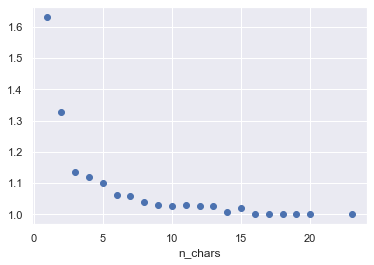

In [134]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_values(ascending=False).plot(style='o');

In [135]:
VOCAB.query('n_chars == "0"')

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,


In [136]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
what,4,"{WP, NN, IN, RB}"
that,4,"{NN, DT, IN, RB}"
there,4,"{NN, EX, NNS, RB}"
i,3,"{NN, NNS, PRP}"
do,3,"{VB, NN, NNS}"
but,3,"{CC, NNS, NN}"
all,3,"{NN, NNS, DT}"
up,3,"{NN, IN, RB}"
were,3,"{NN, VBD, WRB}"


# Add Stems

In [137]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [138]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38882,1,3.552097e-02,2.815238e+01,4.815185,0.171040,PRP,3,"{NN, NNS, PRP}",1,i,i,i
you,38256,3,3.494908e-02,2.861305e+01,4.838602,0.169105,PRP,3,"{NN, NNS, PRP}",1,you,you,you
the,31072,3,2.838608e-02,3.522853e+01,5.138673,0.145867,DT,3,"{NN, NNS, DT}",1,the,the,the
to,26174,2,2.391147e-02,4.182093e+01,5.386153,0.128791,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23702,1,2.165316e-02,4.618264e+01,5.529279,0.119726,DT,3,"{NN, NNS, DT}",1,a,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...
substandard,1,11,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN},0,substandard,substandard,substandard
outhouse,1,8,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN},0,outhous,outhous,outh
renown,1,6,9.135582e-07,1.094621e+06,20.062000,0.000018,NN,1,{NN},0,renown,renown,renown


In [139]:
#stem with the most associated terms
VOCAB.stem_lancaster.value_counts()

fin        25
man        24
op         24
com        23
not        20
           ..
secrecy     1
gehrig      1
misquot     1
insipid     1
disqual     1
Name: stem_lancaster, Length: 15003, dtype: int64

In [140]:
VOCAB[VOCAB.stem_lancaster == 'fin']

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
fine,1732,4,1.582283e-03,6.319983e+02,9.303777,0.014721,NN,1,{NN},0,fine,fine,fin
finally,217,7,1.982421e-04,5.044336e+03,12.300449,0.002438,RB,1,{RB},0,final,final,fin
finish,106,6,9.683717e-05,1.032661e+04,13.334080,0.001291,NN,1,{NN},0,finish,finish,fin
finished,81,8,7.399821e-05,1.351384e+04,13.722150,0.001015,VBN,1,{VBN},0,finish,finish,fin
final,75,5,6.851687e-05,1.459495e+04,13.833181,0.000948,JJ,1,{JJ},0,final,final,fin
finn,54,4,4.933214e-05,2.027076e+04,14.307113,0.000706,NN,1,{NN},0,finn,finn,fin
financial,29,9,2.649319e-05,3.774555e+04,15.204019,0.000403,JJ,1,{JJ},0,financi,financi,fin
finals,26,6,2.375251e-05,4.210081e+04,15.361560,0.000365,NNS,1,{NNS},0,final,final,fin
finishing,18,9,1.644405e-05,6.081228e+04,15.892075,0.000261,VBG,1,{VBG},0,finish,finish,fin


In [141]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38882,1,0.035521,28.152384,4.815185,0.171040,PRP,3,"{NN, NNS, PRP}",1,i,i,i
you,38256,3,0.034949,28.613054,4.838602,0.169105,PRP,3,"{NN, NNS, PRP}",1,you,you,you
the,31072,3,0.028386,35.228534,5.138673,0.145867,DT,3,"{NN, NNS, DT}",1,the,the,the
to,26174,2,0.023911,41.820929,5.386153,0.128791,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23702,1,0.021653,46.182643,5.529279,0.119726,DT,3,"{NN, NNS, DT}",1,a,a,a


In [142]:
TOKENS.head()

pos_tuple pos  \
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0          (Please, VB)  VB   
                                           1            (Luke, NN)  NN   
                                  1        0          (Please, VB)  VB   
                                           1          (please, NN)  NN   
                                           2          (please, NN)  NN   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0            Please   please  
                                           1              Luke     luke  
                                  1        0            Please   please  
                                           1            please   please  
                                           2            please   please

## Gather POS Information

In [143]:
pos_info = f'{data_home}/misc/upenn_tagset.txt'
POS = pd.DataFrame([(line.split()[0], ' '.join(line.split()[1:])) 
                    for line in open(pos_info, 'r').readlines()])
POS.columns = ['pos_id', 'pos_def']
POS = POS.set_index('pos_id')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)

In [144]:
VOCAB['max_pos_group'] =  VOCAB.max_pos.apply(lambda x: x[:2])
TOKENS['pos_group'] = TOKENS.pos.apply(lambda x: x[:2])

In [145]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_group
term_str,,,,,,,,,,,,,,
i,38882,1,0.035521,28.152384,4.815185,0.171040,PRP,3,"{NN, NNS, PRP}",1,i,i,i,PR
you,38256,3,0.034949,28.613054,4.838602,0.169105,PRP,3,"{NN, NNS, PRP}",1,you,you,you,PR
the,31072,3,0.028386,35.228534,5.138673,0.145867,DT,3,"{NN, NNS, DT}",1,the,the,the,DT
to,26174,2,0.023911,41.820929,5.386153,0.128791,TO,3,"{TO, NN, NNS}",1,to,to,to,TO
a,23702,1,0.021653,46.182643,5.529279,0.119726,DT,3,"{NN, NNS, DT}",1,a,a,a,DT


In [146]:
VOCAB.reset_index().query('term_str == "nan"') #[21860:21870]

,term_str,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_group
18695,nan,1,3,9.135582e-07,1094621.0,20.062,0.000018,NN,1,{NN},0,nan,nan,nan,NN


In [147]:
TOKENS.sample(10)

pos_tuple  pos  \
Season Episode line_num Character sent_num token_num                        
02     21      665      WOMAN     0        4              (take, VB)   VB   
06     19      193      RORY      0        1          (happens, NNS)  NNS   
05     19      306      HONOR     1        1              (come, VB)   VB   
       12      352      LORELAI   1        3                 (a, DT)   DT   
06     22      629      LORELAI   6        9            (cared, VBN)  VBN   
03     09      543      LORELAI   0        3             (think, NN)   NN   
05     03      519      LUKE      1        0              (Well, RB)   RB   
02     05      263      PARIS     0        1              (you, PRP)  PRP   
01     04      245      LORELAI   1        6                (to, TO)   TO   
07     20      425      LORELAI   0        4                (I, PRP)  PRP   

                                                     token_str term_str  \
Season Episode line_num Character sent_num token_num                      
02     21      665      WOMAN     0        4              take     take   
06     19      193      RORY      0        1           happens  happens   
05     19      306      HONOR     1        1              come     come   
       12      352      LORELAI   1        3                 a        a   
06     22      629      LORELAI   6        9             cared    cared   
03     09      543      LORELAI   0        3             think    think   
05     03      519      LUKE      1        0              Well     well   
02     05      263      PARIS     0        1               you      you   
01     04      245      LORELAI   1        6                to       to   
07     20      425      LORELAI   0        4                 I        i   

                                                     pos_group  
Season Episode line_num Character sent_num token_num            
02     21      665      WOMAN     0        4                VB  
06     19      193      RORY      0        1                NN  
05     19      306      HONOR     1        1                VB  
       12      352      LORELAI   1        3                DT  
06     22      629      LORELAI   6        9                VB  
03     09      543      LORELAI   0        3                NN  
05     03      519      LUKE      1        0                RB  
02     05      263      PARIS     0        1                PR  
01     04      245      LORELAI   1        6                TO  
07     20      425      LORELAI   0        4                PR

# Character List
Extract Character List to build table of character information

In [148]:
#unique characters
#DATA.head()
CHARACTERS_LIST = DATA.drop_duplicates(['Character'])

In [149]:
CHARACTERS_LIST = CHARACTERS_LIST[['Character']] 

In [150]:
CHARACTERS_LIST

,Character
61758,LORELAI
61759,LUKE
61771,JOEY
61793,RORY
61836,BELLBOY
...,...
61714,ANNABELLE
61716,WANNABELLE
71787,TOGETHER
100101,CHRISTIANE AMANPOUR


In [151]:
TOKENS.query("term_str == 'zymurgy'")

,,,,,,pos_tuple,pos,token_str,term_str,pos_group
Season,Episode,line_num,Character,sent_num,token_num,,,,,
07,06,657,LANE,1,10,"(zymurgy, NN)",NN,zymurgy,zymurgy,NN


# Export Data

In [152]:
#save to csv
#DATA.to_csv(f'{data_home}/output/{data_prefix}-DATA.csv')

In [153]:
#save output
VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB-WOA.csv')

In [154]:
TOKENS.to_csv(f'{data_home}/output/{data_prefix}-CORPUS-WOA.csv')

**Note: TOKENS table is CORPUS table. In analysis notebook, will import TOKENS named as CORPUS**

In [ ]:
#save output
#TOKENS.to_csv(f'{data_home}/output/{data_prefix}-TOKENS2.csv')

In [ ]:
#save output
#LIB2.to_csv(f'{data_home}/output/{data_prefix}-LIB-EPISODE.csv')

In [ ]:
#save output
#LIB.to_csv(f'{data_home}/output/{data_prefix}-LIB-SEASON.csv')

In [ ]:
#CHARACTER_LIST.to_csv(f'{data_home}/output/{data_prefix}-CHARCTERS_LIST.csv')